Loaded DL model.
DL AUC: 0.7187
DL F1 @0.5: 0.4337; best_thresh=0.518, F1_best=0.4357


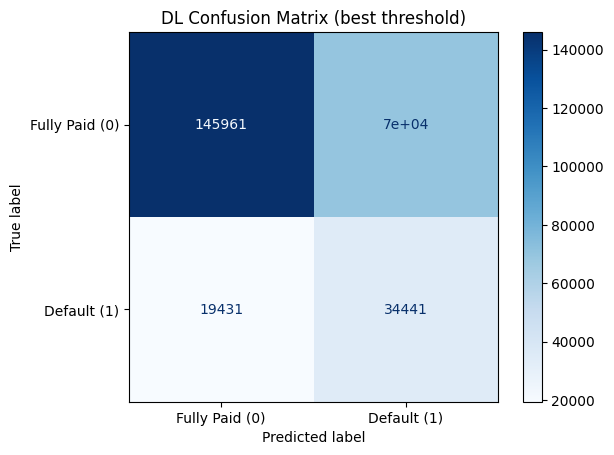

RL policy avg reward per loan: 0.0691
RL policy total reward (test set): 18621.94
RL approval rate: 0.564
DL avg reward per loan: -0.0354; total: -9547.23; approve rate: 0.387
Number of disagreements between DL and RL on test set: 158661

Examples (first 10 disagreements) — format: idx, dl_action, rl_action, target, loan_amnt, int_rate
0 1 0 1 2.018211249464325 0.1570472710688516
1 0 1 0 -0.964762387180335 -0.472453207357589
4 0 1 0 -1.0737556546731206 -0.472453207357589
5 0 1 0 -0.5517352682603051 -0.9110052073280092
6 1 0 1 0.4119946758864313 2.4652156919658004
10 1 0 0 0.0678054101197397 0.908251175324404
12 0 1 1 -1.4867827735931505 0.0899005533700312
17 0 1 0 -0.3911136109025157 -1.1795920781232907
19 0 1 0 -1.17127594664035 -0.0947529203017248
20 1 0 1 1.1003732074198145 0.2955373763226686
Found 2459 applicants where DL says high default prob (>=0.8) but RL approves. Sample:
313 dl_p= 0.8238573 rl_action= 1 true= 1 loan_amnt= -0.0985527350008278 int_rate= 1.3174264863015903
338 d

In [ ]:
# ---------- Imports ----------
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ---------- Load data & models (adjust paths) ----------
processed_path = "/content/drive/MyDrive/loan_data_processed.csv"
processed_df = pd.read_csv(processed_path)

# features and target
if 'target' not in processed_df.columns:
    raise ValueError("processed_df must include 'target' column")
y = processed_df['target'].values
X = processed_df.drop(columns=['target']).values.astype(np.float32)

# monetary fields must be present (for RL reward calc); adapt column names if needed
loan_amnt = processed_df['loan_amnt'].values.astype(float)
int_rate = processed_df['int_rate'].astype(str).str.replace('%','').astype(float)  # percent values

# load DL model (if saved)
dl_model_path = "/content/drive/MyDrive/nn_best_model.h5"
try:
    dl_model = load_model(dl_model_path)
    print("Loaded DL model.")
except Exception as e:
    dl_model = None
    print("DL model not loaded:", e)

# If you used a stacker (XGBoost/LightGBM), load or reference it similarly
# xgb_model = ...
# lgb_model = ...

# ---------- Train/test split same as earlier (ensure same seed) ----------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, loan_train, loan_test, int_train, int_test = train_test_split(
    X, y, loan_amnt, int_rate, test_size=0.2, random_state=42, stratify=y
)

# Convert test sets and actions to numpy arrays for consistent indexing
y_test = np.array(y_test)
loan_test = np.array(loan_test)
int_test = np.array(int_test)


# ---------- DL metrics ----------
if dl_model is not None:
    y_proba = dl_model.predict(X_test, batch_size=1024, verbose=0).reshape(-1)
    auc = roc_auc_score(y_test, y_proba)
    # choose threshold: either 0.5 or optimize for F1
    thresh = 0.5
    y_pred_05 = (y_proba >= thresh).astype(int)
    f1_05 = f1_score(y_test, y_pred_05)
    # optimal threshold maximizing F1 on validation/test
    prec, rec, thr = precision_recall_curve(y_test, y_proba)
    f1_scores = 2*prec*rec/(prec+rec+1e-12)
    best_idx = np.nanargmax(f1_scores)
    best_thresh = thr[best_idx] if best_idx < len(thr) else 0.5
    y_pred_best = (y_proba >= best_thresh).astype(int)
    f1_best = f1_score(y_test, y_pred_best)

    print(f"DL AUC: {auc:.4f}")
    print(f"DL F1 @0.5: {f1_05:.4f}; best_thresh={best_thresh:.3f}, F1_best={f1_best:.4f}")

    # Confusion matrix at best threshold
    cm = confusion_matrix(y_test, y_pred_best)
    ConfusionMatrixDisplay(cm, display_labels=["Fully Paid (0)","Default (1)"]).plot(cmap='Blues')
    plt.title("DL Confusion Matrix (best threshold)")
    plt.show()
else:
    print("DL model unavailable; skip DL metrics")

# ---------- RL policy evaluation (assuming cql agent in memory) ----------
# This code expects `cql` object from d3rlpy trained earlier.
# If you saved the agent differently, load it accordingly (d3rlpy has load functionality).
try:
    # predict actions for each test state (one action per sample)
    # if cql.predict returns shape (N,1)
    rl_actions = cql.predict(X_test)    # array of 0/1 actions
    rl_actions = np.array(rl_actions).reshape(-1).astype(int)
    # compute rewards (monetary)
    int_frac = int_test / 100.0
    rl_rewards = np.where(
        rl_actions == 0,
        0.0,
        np.where(y_test == 0, loan_test * int_frac, -loan_test)
    )
    avg_reward = rl_rewards.mean()
    total_reward = rl_rewards.sum()
    approve_rate = rl_actions.mean()
    print(f"RL policy avg reward per loan: {avg_reward:.4f}")
    print(f"RL policy total reward (test set): {total_reward:.2f}")
    print(f"RL approval rate: {approve_rate:.3f}")
except Exception as e:
    print("RL policy evaluation failed (cql missing?)", e)

# ---------- Compare DL policy (thresholded) vs RL policy ----------
if dl_model is not None:
    # Use DL best threshold for decisions
    dl_actions = y_pred_best
    # compute DL rewards
    dl_rewards = np.where(
        dl_actions == 0,
        0.0,
        np.where(y_test == 0, loan_test * (int_test/100.0), -loan_test)
    )
    print(f"DL avg reward per loan: {dl_rewards.mean():.4f}; total: {dl_rewards.sum():.2f}; approve rate: {dl_actions.mean():.3f}")

    # Compare approval vector differences
    if 'rl_actions' in locals():
        diffs = np.where(dl_actions != rl_actions)[0]
        print(f"Number of disagreements between DL and RL on test set: {len(diffs)}")
        # show top 10 disagreement examples where DL denies & RL approves and vice versa
        print("\nExamples (first 10 disagreements) — format: idx, dl_action, rl_action, target, loan_amnt, int_rate")
        for idx in diffs[:10]:
            print(idx, dl_actions[idx], rl_actions[idx], y_test[idx], loan_test[idx], int_test[idx])
else:
    print("DL/RL comparison skipped because DL model missing")

# ---------- Find high-risk applicant flagged by DL but RL approves ----------
if dl_model is not None and 'rl_actions' in locals():
    # high-risk per DL = dl_proba high and dl_action=deny (1?), define risk as high prob of default
    # dl_proba is prob(default); higher means riskier. If DL denies when prob>best_thresh maybe.
    # We'll look for applicants where DL predicts high default prob (>=0.8) but RL approves.
    high_risk_idx = np.where((y_proba >= 0.8) & (rl_actions == 1))[0]
    print(f"Found {len(high_risk_idx)} applicants where DL says high default prob (>=0.8) but RL approves. Sample:")
    for i in high_risk_idx[:10]:
        print(i, "dl_p=", y_proba[i], "rl_action=", rl_actions[i], "true=", y_test[i], "loan_amnt=", loan_test[i], "int_rate=", int_test[i])